# Setup

In [1]:
from qiskit import *
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q-utokyo',group='internal',project='icepp')

from qiskit.visualization import plot_histogram

In [2]:
backend = provider.get_backend('ibmq_manila')

In [3]:
import icepp
dir(icepp)

['MeasurementErrorAnalysis',
 'MeasurementErrorExperiment',
 'MeasurementErrorMitigation',
 'MeasurementErrorMitigation_demo',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'aqcel',
 'circuit',
 'cnot_error',
 'compiler',
 'decompose',
 'demo',
 'error_mitigation',
 'experiment',
 'fiim',
 'measurement_error',
 'mitigation',
 'optimizer',
 'other_passes',
 'pass_manager',
 'qc_experiment',
 'remove_controlled_operations',
 'run',
 'simulator',
 'transpiler',
 'zne']

# Benchmarks

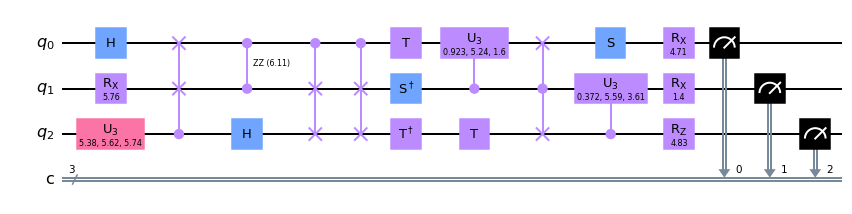

In [35]:
from qiskit.circuit.random import random_circuit

test = random_circuit(3, 10, measure=True)

test.draw("mpl")

# Transpile and Experiment Run

In [36]:
transpiled_qcs = icepp.transpiler([test],backend,level=3).transpile()

In [37]:
transpiled_qcs[0].count_ops()

OrderedDict([('rz', 77),
             ('cx', 49),
             ('sx', 47),
             ('measure', 3),
             ('x', 2),
             ('barrier', 1)])

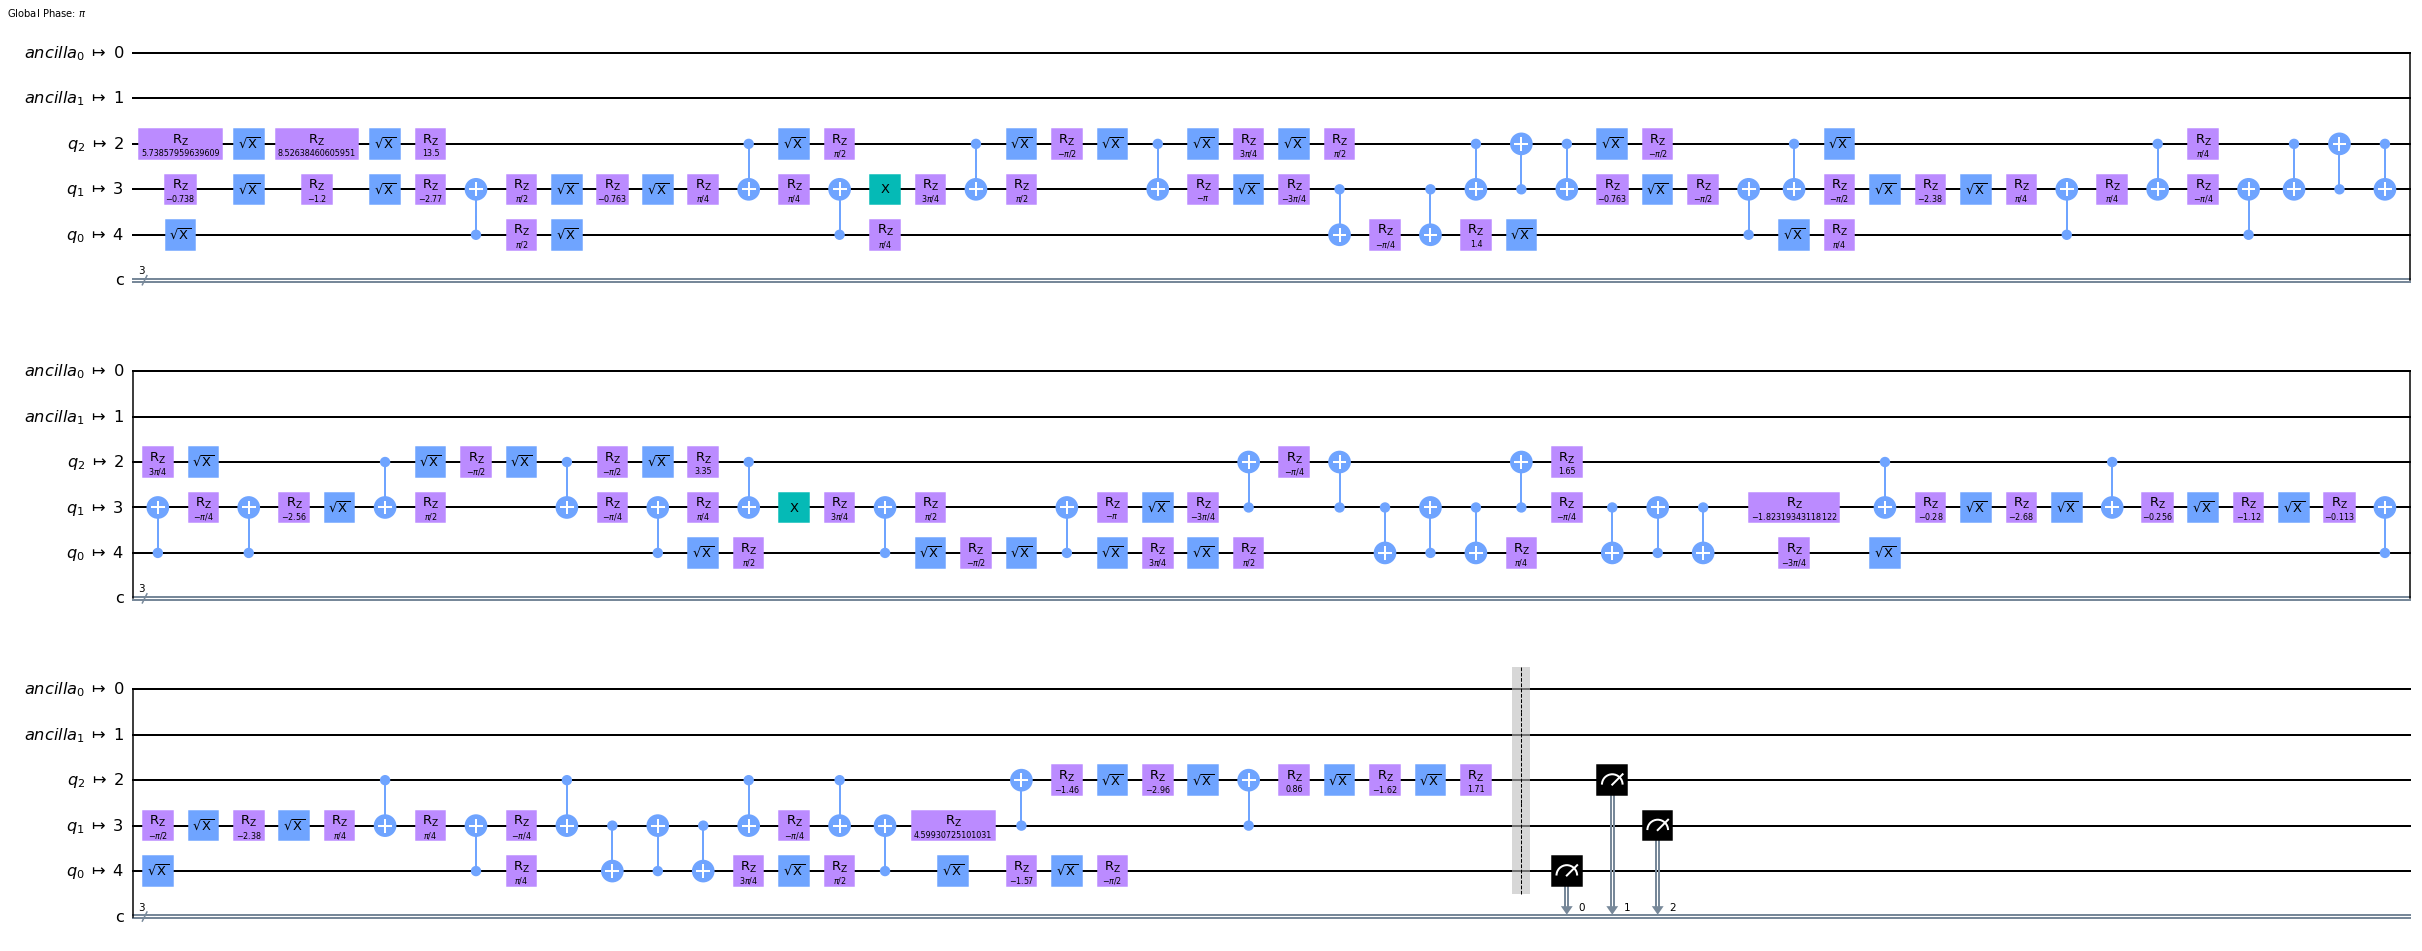

In [38]:
transpiled_qcs[0].draw('mpl',fold=50) 

In [39]:
results = icepp.qc_experiment(qc_list=transpiled_qcs, backend=backend, shots=1024).run()

Job id : b2e32bf968b7472594c616fcc8c97696-1639321153656613
Job Status: job has successfully run


In [40]:
results.get_counts(0)

{'000': 142,
 '001': 135,
 '010': 117,
 '011': 135,
 '100': 131,
 '101': 93,
 '110': 147,
 '111': 124}

# Simulator

In [41]:
simulation_counts = icepp.simulator(test).aer_simulator(shots=1024)
print(simulation_counts)

{'011': 223, '111': 297, '100': 78, '110': 73, '001': 96, '101': 171, '000': 32, '010': 54}


In [42]:
icepp.simulator(test).statevector_simulator(output='statevector')

Statevector([-0.17895103+0.04277499j,  0.24228214-0.16330777j,
              0.06615566-0.22258884j, -0.01696403-0.45353587j,
             -0.01162413+0.25528065j, -0.19466412-0.39605532j,
              0.25519234-0.07292693j, -0.49228043+0.21916452j],
            dims=(2, 2, 2))


In [43]:
icepp.simulator(test).statevector_simulator(output='probabilities_distribution')

{'000': 0.03385317240332564,
 '001': 0.0853700617704629,
 '010': 0.05392236303594124,
 '011': 0.2059825678338853,
 '100': 0.06530332860179701,
 '101': 0.1947539369545488,
 '110': 0.07044146751542475,
 '111': 0.29037310188461457}

# Meausrement Error Mitigation

※The number of measurements and clibits must be identical.
<br>
When you want to do mitigate measurement error, then do not use "icepp.qc_experiment" twice for raw experiment and mitigation experiment inidividually bacause that cost twice times. In "icepp.MeasurementErrorMitigation_demo", those two jobs are merged.

In [44]:
info_list = icepp.MeasurementErrorMitigation_demo(backend).measured_qubits(transpiled_qcs[0])

In [45]:
meas_mit_results = icepp.MeasurementErrorMitigation_demo(backend).apply([transpiled_qcs[0]], info_list, shots=1024)

Job id : 36228c3eb3384eb2b06c9f54cf8f3005-1639321401197531
Job Status: job has successfully run


In [46]:
raw_counts = meas_mit_results[0].get_counts(0)
meas_mit_counts = meas_mit_results[1].get_counts(0)

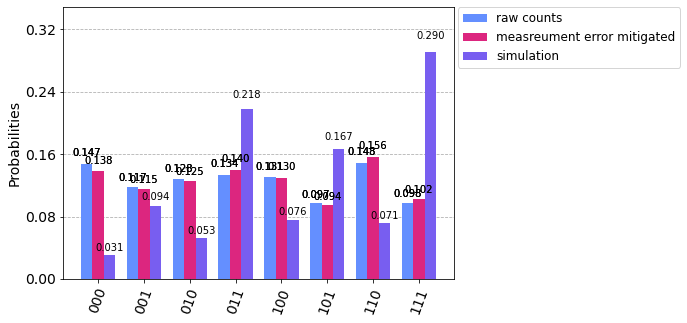

In [47]:
legend = ['raw counts','measreument error mitigated','simulation']
plot_histogram([raw_counts, meas_mit_counts, simulation_counts], legend=legend)

# CNOT Error Mitigation

In [48]:
qc_3cx = icepp.zne(1,transpiled_qcs[0]).fiim_generate_circs()

In [49]:
cnot_mit_results = icepp.qc_experiment(qc_list=[qc_3cx], backend=backend, shots=1024).run()

Job id : b13cb38d604948a383a6d7338b6f1e41-1639321429229067
Job Status: job has successfully run


In [50]:
qc_3cx_counts = cnot_mit_results.get_counts(0)
cnot_mit_counts = icepp.zne(1,transpiled_qcs[0]).apply(raw_counts, qc_3cx_counts)

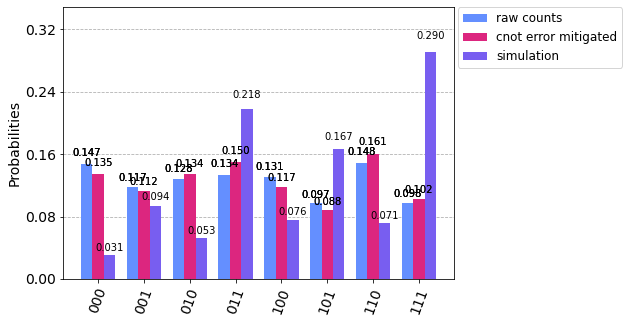

In [51]:
legend = ['raw counts','cnot error mitigated','simulation']
plot_histogram([raw_counts, cnot_mit_counts, simulation_counts], legend=legend)

# Raw + Measurment error mitigation + CNOT error mitigation in 1 job

In [52]:
all_mitigated_counts = icepp.pass_manager(transpiled_qcs[0], level=1, backend=backend, shots=1024).auto_manager()

Job id : e22e46d9714b4c649dd3f4894de4bed9-1639321481188687
Job Status: job has successfully run
Raw counts: {'000': 146, '001': 137, '010': 98, '011': 150, '100': 140, '101': 90, '110': 150, '111': 113}
Measurement error mitigated counts {'000': 134.41112903619563, '001': 135.27786044806598, '010': 92.27386902462804, '011': 159.83406850182223, '100': 135.97624017840104, '101': 88.34411526564836, '110': 154.45045868180125, '111': 123.43225886343761}
CNOT error mitigated counts {'000': 122.415471180585, '001': 138.88595621738017, '010': 77.2107334946178, '011': 189.10729350744134, '100': 127.32570067016256, '101': 77.09658168870246, '110': 158.69439231409524, '111': 133.26387092701557}


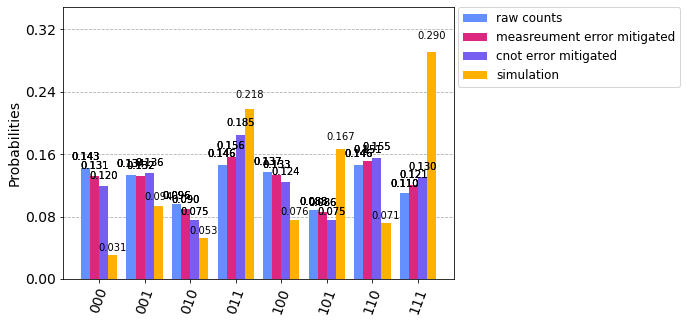

In [53]:
raw_counts, meas_mit_counts, cnot_mit_counts = all_mitigated_counts[0], all_mitigated_counts[1], all_mitigated_counts[2]

legend = ['raw counts','measreument error mitigated','cnot error mitigated','simulation']
plot_histogram([raw_counts, meas_mit_counts, cnot_mit_counts, simulation_counts], legend=legend)

In [54]:
import math

def fidelity(count1,count2,shots):
    fidelity=0
    for key in count1.keys():
        if (key in count2) and (count1[key] >0) and (count2[key] >0):
            fidelity += math.sqrt((count1[key]*count2[key]))/shots
    return fidelity

def all_fidelities(sim_counts, counts_list, shots):
    fidelity_list = []
    for counts in counts_list:
        each_fidelity = fidelity(sim_counts, counts ,shots)
        fidelity_list.append(each_fidelity)
    return fidelity_list

In [55]:
all_fidelities(sim_counts=simulation_counts, counts_list=all_mitigated_counts, shots=1024)

[0.9326834481621743, 0.939912494849874, 0.9463254352930272]

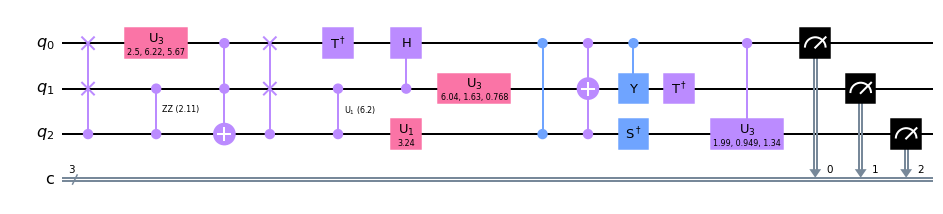

In [69]:
from qiskit.circuit.random import random_circuit

test = random_circuit(3, 10, measure=True)

test.draw("mpl")